In [15]:
from igraph import *
import networkx as nx
import random
import louvain
import os,sys
import time
import subprocess
from infomap import Infomap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:

def clique(g, size, idx, num_nodes):
  for i in range(idx,num_nodes-1):
    for j in range(idx - size,idx):
      g[i,j] = 0

In [17]:
def Print(g,num_nodes):
  G = nx.Graph()
  for i in range(num_nodes):
    G.add_node(i)
  for i in range(num_nodes):
    for j in range(i+1, num_nodes):
      if g[i,j] == 1:
        G.add_edge(i,j)
  nx.draw(G, with_labels=True)

In [18]:
def walktrap(g):
  k = g.community_walktrap()
  k = k.as_clustering()
  print(k)

In [19]:
def infomap(g):
  k = g.community_infomap()
  print(k)

In [20]:
def hub_node(clq):
    num_nodes = int((clq*(clq+1))/2) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-1):
        size = size + i
        clique(g,i,size,num_nodes)
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [21]:
def hub_node2(clq):
    num_nodes = int(clq*(clq+1)) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-1):
        size = size + i
        clique(g,i,size,num_nodes)
        size = size + i
        clique(g,i,size,num_nodes)
    g[num_nodes-2, num_nodes-3] = 0
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [22]:
def alt_hub_node(clq):
    num_nodes = int((clq+1)*(clq+1)/4) + 1
    g = Graph.Full(num_nodes)
    size = 0
    for i in range(clq,1,-2):
        size = size + i
        clique(g,i,size,num_nodes)
    walktrap(g)
    Print(g, num_nodes)
    infomap(g)

In [23]:
def creat_random_connected(offset,size,number_of_edges = 100000000):

    edges = []
    for i in range(size-1):
        edges.append((offset + i,offset + i + 1))
    edges.append((offset,offset + size - 1))
    ret_edges = edges[:];
    
    edges = []
    for i in range(size):
        for j in range(i + 1,size):
            if((offset + i,offset + j) not in ret_edges):
                edges.append((offset + i,offset + j))

    last = len(edges)-1
    for i in range(min(number_of_edges,len(edges))):
        ind = random.randint(0,last)
        ret_edges.append(edges[ind])
        tmp = edges[ind]
        edges[ind] = edges[last]
        edges[last] = tmp
        last -= 1
    return ret_edges

In [24]:
def ring_of_clique(ring_size , clique_size):

    total_vert = ring_size*clique_size;

    edges = creat_random_connected(0,clique_size);import random

    offset = clique_size
    prev_connector = offset - 1

    for i in range(ring_size - 1):
        new_clique = creat_random_connected(offset,clique_size);
        new_clique.append((prev_connector,offset))
        edges.extend(new_clique)
        offset += clique_size
        prev_connector += clique_size

    edges.append((0,prev_connector))

    return [total_vert, edges]


In [25]:
def line_star_graph(total_vert, line_length):
    edges = []

    for i in range(1,line_length):
        edges.append((i-1,i))

    middle_node = line_length//2
    rem_vert = total_vert - line_length
    offset = line_length

    for i in range(rem_vert):
        edges.append((middle_node,offset + i))

    return [total_vert, edges]

In [26]:
def run_louvain(total_vert,edges):
                
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    
#     Print(g,total_vert)
    
    part = louvain.find_partition(g, louvain.ModularityVertexPartition);
    print(part)
    return part

In [67]:
def run_maxperm(total_vert, edges):
    
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    
    input_file = open("input.dat", "w")
    input_file.write(str(g.vcount()) + " " + str(g.ecount()) + "\n")
    for i in g.es:
        m1 = i.tuple[0]
        m2 = i.tuple[1]
        input_file.write(str(m1) + " " + str(m2) + "\n")
#         input_file.write(str(m2) + " " + str(m1) + "\n")
    input_file.close()
    
    returned_value = subprocess.check_output("bash compile.sh", shell = True)
    returned_value = returned_value.decode("utf-8")
    
    #print(returned_value)
    
    output_file = open("output.txt","r")
    partitions = output_file.readlines() 

    dicti={}
    for line in partitions[2:]:
        #print(line.strip())
        pair = line.split('\t')
        pair = list(map(int,pair))
        if pair[1] in dicti:
            dicti[pair[1]].append(pair[0])
        else:
            dicti[pair[1]] = [pair[0]]
    
    print("total partitions : " + str(len(dicti.keys())) )
    for i in dicti.keys():
        print ("[" + str(i) + "] : "),
        print(list(dicti[i]))
    return dicti
    

In [68]:
def hub_surr_cliq(total_number_of_cliq,list_of_sizes):
    
    total_vert = sum(list_of_sizes) + 1
    offset = 1
    edges = []
    
    for i in range(total_number_of_cliq):
        edges.append((0,offset))
        edges.extend(creat_random_connected(offset,list_of_sizes[i]))
        offset += list_of_sizes[i]
        
    return [total_vert,edges]
def hub_surr_cliq2(total_number_of_cliq,list_of_sizes):
    
    total_vert = sum(list_of_sizes) + 1
    offset = 1
    edges = []
    for i in range(1,total_vert):
        edges.append((0,i))
    for i in range(total_number_of_cliq):
        edges.append((0,offset))
        edges.extend(creat_random_connected(offset,list_of_sizes[i]))
        offset += list_of_sizes[i]
        
    return [total_vert,edges]


In [69]:
def comm_surr_comm(middle_size,outer_size,count_outer,beta):
    edges = []

    if(middle_size < count_outer):
        print "add more vertices to middle comm"
        return None

    g = Graph()
    total_vert = count_outer*outer_size + middle_size
    g.add_vertices(total_vert)

    edges.extend(creat_random_connected(0,middle_size))
    
    offset = middle_size
    for i in range(count_outer):
        edges.extend(creat_random_connected(offset,outer_size))
        beta1 = beta
        for j in range(offset,offset + outer_size):
            if(beta1 == 0):
                break
            beta1 -= 1
            edges.append((i,j))
        offset += outer_size

    return [total_vert,edges]


In [70]:
def hub_node_graph(left_size,right_size):
    edges = []

#     g = Graph()
    total_vert = left_size + right_size + 1
#     g.add_vertices(total_vert)
    
    hub_node = 0
    offset_right = left_size + 1
    
    edges.extend(creat_random_connected(0,left_size + 1))
    edges.extend(creat_random_connected(offset_right,right_size))

    for i in range(right_size):
        edges.append((0,offset_right + i));
#     print(edges)
#     g.add_edges(edges)
    return [total_vert, edges]


In [71]:
def ring_of_clique_temp(ring_size , clique_list):

    total_vert = sum(clique_list);

    edges = creat_random_connected(0,clique_list[0]);

    offset = clique_list[0]
    prev_connector = offset - 1

    for i in range(1,ring_size):
        new_clique = creat_random_connected(offset,clique_list[i]);
        new_clique.append((prev_connector,offset))
        edges.extend(new_clique)
        offset += clique_list[i]
        prev_connector += clique_list[i]

    edges.append((0,prev_connector))

    return [total_vert, edges]

In [72]:
def run_infomap(total_vert,edges):
    im = Infomap("--two-level --directed")
#     im.add_link(0, 1)
    for i in edges:
        im.addLink(i[0],i[1])
        im.addLink(i[1],i[0])
    im.run()
    sets = {}

#     print("Found " + str(im.num_top_modules)+ " modules with codelength: " + str(im.codelength))
    print("Result")
    print("\n#node module")
    for node in im.tree:
        if node.is_leaf:
            if(node.module_id in sets):
                sets[node.module_id].append(node.node_id)
            else:
                sets[node.module_id] = [node.node_id]
            print(node.node_id, node.module_id)
    print("total partitions : " + str(len(sets.keys())) )
    for i in sets.keys():
        print ("[" + str(i) + "] : "),
        print(sets[i])
        
    g = Graph()
    g.add_vertices(total_vert)
    g.add_edges(edges)
    Print(g,total_vert)

In [73]:
def hub_node_generic(x,y,alpha,beta):
    total_vert = x + y + 1;
    x,y = y,x
    alpha,beta = beta,alpha
    x = x + alpha
    y = y + beta
    edges = creat_random_connected(1,y);
    offset = y + 1;
    edges.extend(creat_random_connected(offset,x));

    for i in range(1,y + 1):
        if(beta == 0):
            break
        edges.append((0,i))
        beta -= 1
    for i in range(y + 1,y + x + 1):
        if(alpha == 0):
            break
        edges.append((0,i))
        alpha -= 1

    return [total_vert, edges]

In [74]:
graph_1 = ring_of_clique(30,5)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 150 elements and 17 clusters
[ 0] 0, 1, 2, 3, 4, 145, 146, 147, 148, 149
[ 1] 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
[ 2] 15, 16, 17, 18, 19, 20, 21, 22, 23, 24
[ 3] 25, 26, 27, 28, 29, 30, 31, 32, 33, 34
[ 4] 35, 36, 37, 38, 39, 40, 41, 42, 43, 44
[ 5] 45, 46, 47, 48, 49, 50, 51, 52, 53, 54
[ 6] 60, 61, 62, 63, 64, 65, 66, 67, 68, 69
[ 7] 70, 71, 72, 73, 74, 75, 76, 77, 78, 79
[ 8] 85, 86, 87, 88, 89, 90, 91, 92, 93, 94
[ 9] 95, 96, 97, 98, 99, 100, 101, 102, 103, 104
[10] 110, 111, 112, 113, 114, 115, 116, 117, 118, 119
[11] 125, 126, 127, 128, 129, 130, 131, 132, 133, 134
[12] 135, 136, 137, 138, 139, 140, 141, 142, 143, 144
[13] 55, 56, 57, 58, 59
[14] 80, 81, 82, 83, 84
[15] 105, 106, 107, 108, 109
[16] 120, 121, 122, 123, 124



MAXPERM : 
total partitions : 30
[2] :  [0, 1, 2, 3, 4]
[132] :  [130, 131, 132, 133, 134]
[7] :  [5, 6, 7, 8, 9]
[137] :  [135, 136, 137, 138, 139]
[12] :  [10, 11, 12, 13, 14]
[142] :  [140, 141, 142, 143, 144]
[17] :  [15, 16, 17,

{2: [0, 1, 2, 3, 4],
 7: [5, 6, 7, 8, 9],
 12: [10, 11, 12, 13, 14],
 17: [15, 16, 17, 18, 19],
 22: [20, 21, 22, 23, 24],
 27: [25, 26, 27, 28, 29],
 32: [30, 31, 32, 33, 34],
 37: [35, 36, 37, 38, 39],
 42: [40, 41, 42, 43, 44],
 47: [45, 46, 47, 48, 49],
 52: [50, 51, 52, 53, 54],
 57: [55, 56, 57, 58, 59],
 62: [60, 61, 62, 63, 64],
 67: [65, 66, 67, 68, 69],
 72: [70, 71, 72, 73, 74],
 77: [75, 76, 77, 78, 79],
 82: [80, 81, 82, 83, 84],
 87: [85, 86, 87, 88, 89],
 92: [90, 91, 92, 93, 94],
 97: [95, 96, 97, 98, 99],
 102: [100, 101, 102, 103, 104],
 107: [105, 106, 107, 108, 109],
 112: [110, 111, 112, 113, 114],
 117: [115, 116, 117, 118, 119],
 122: [120, 121, 122, 123, 124],
 127: [125, 126, 127, 128, 129],
 132: [130, 131, 132, 133, 134],
 137: [135, 136, 137, 138, 139],
 142: [140, 141, 142, 143, 144],
 147: [145, 146, 147, 148, 149]}

LOUVAIN : 
Clustering with 31 elements and 3 clusters
[0] 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30
[1] 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
[2] 0, 1, 2, 3, 4, 5, 6, 7, 8



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 8.6416666667 :: iter 1
Old_SumQ 8.6416666667  
SumQ 29.3833333333 :: iter 2
Old_SumQ 29.3833333333  
SumQ 29.3833333333 :: iter 3
Our MaxPerm Implementation took 0.001880 seconds

total partitions : 1
[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


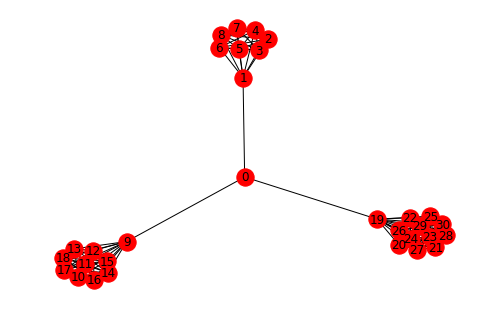

In [33]:
graph_1 = hub_surr_cliq(3,[8,10,12])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 31 elements and 3 clusters
[0] 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30
[1] 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
[2] 0, 1, 2, 3, 4, 5, 6, 7, 8



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 6.8416666667 :: iter 1
Old_SumQ 6.8416666667  
SumQ 28.0400000000 :: iter 2
Old_SumQ 28.0400000000  
SumQ 28.0400000000 :: iter 3
Our MaxPerm Implementation took 0.004772 seconds

total partitions : 3
[2] :  [1, 2, 3, 4, 5, 6, 7, 8]
[20] :  [0, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[10] :  [9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


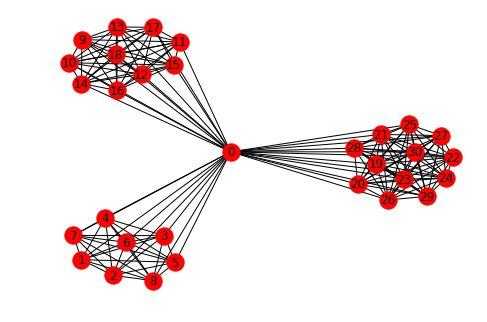

In [34]:
graph_1 = hub_surr_cliq2(3,[8,10,12])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 184 elements and 9 clusters
[0] 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
    84, 85, 86, 87, 88
[1] 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
    125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
    140, 141, 142, 143
[2] 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
    31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44
[3] 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105,
    106, 107, 108, 109
[4] 0, 45, 46, 47, 154, 155, 156, 157, 158, 159, 160, 161
[5] 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
[6] 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183
[7] 144, 145, 146, 147, 148, 149, 150, 151, 152, 153
[8] 162, 163, 164, 165, 166, 167, 168, 169, 170, 171



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 64.422750421

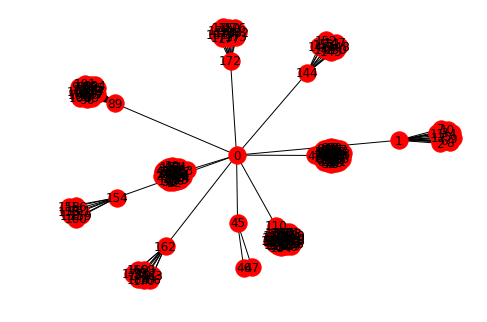

In [35]:
graph_1 = hub_surr_cliq(10,[12,32,3,41,21,34,10,8,10,12])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 45 elements and 6 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
[1] 20, 21, 22, 23, 24
[2] 25, 26, 27, 28, 29
[3] 30, 31, 32, 33, 34
[4] 35, 36, 37, 38, 39
[5] 40, 41, 42, 43, 44



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 9.8038847118 :: iter 1
Old_SumQ 9.8038847118  
SumQ 40.0238095238 :: iter 2
Old_SumQ 40.0238095238  
SumQ 40.2619047619 :: iter 3
Old_SumQ 40.2619047619  
SumQ 40.2619047619 :: iter 4
Our MaxPerm Implementation took 0.015553 seconds

total partitions : 6
[32] :  [30, 31, 32, 33, 34]
[37] :  [35, 36, 37, 38, 39]
[42] :  [40, 41, 42, 43, 44]
[20] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[22] :  [20, 21, 22, 23, 24]
[27] :  [25, 26, 27, 28, 29]


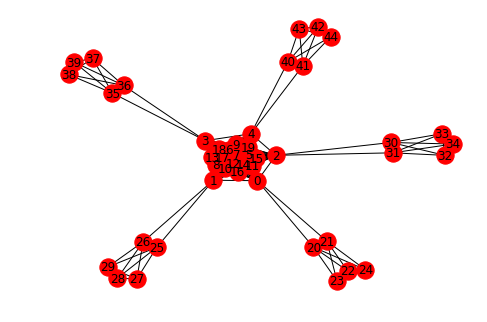

In [95]:
graph_1 = comm_surr_comm(20,5,5,2)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 35 elements and 6 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
[1] 20, 21, 22
[2] 23, 24, 25
[3] 26, 27, 28
[4] 29, 30, 31
[5] 32, 33, 34



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ -7.7675438596 :: iter 1
Old_SumQ -7.7675438596  
SumQ 32.5833333333 :: iter 2
Old_SumQ 32.5833333333  
SumQ 33.0833333333 :: iter 3
Old_SumQ 33.0833333333  
SumQ 33.0833333333 :: iter 4
Our MaxPerm Implementation took 0.014477 seconds

total partitions : 6
[34] :  [32, 33, 34]
[20] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[22] :  [20, 21, 22]
[25] :  [23, 24, 25]
[28] :  [26, 27, 28]
[31] :  [29, 30, 31]


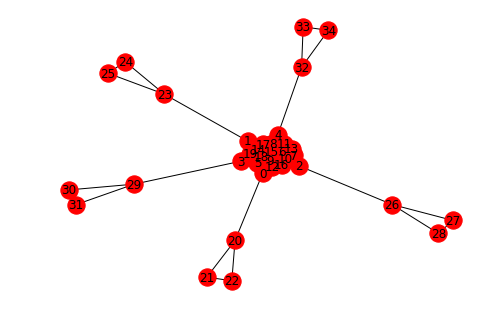

In [37]:
graph_1 = comm_surr_comm(20,3,5,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 400 elements and 100 clusters
[  0] 0, 100, 101, 102
[  1] 1, 103, 104, 105
[  2] 2, 106, 107, 108
[  3] 3, 109, 110, 111
[  4] 4, 112, 113, 114
[  5] 5, 115, 116, 117
[  6] 6, 118, 119, 120
[  7] 7, 121, 122, 123
[  8] 8, 124, 125, 126
[  9] 9, 127, 128, 129
[ 10] 10, 130, 131, 132
[ 11] 11, 133, 134, 135
[ 12] 12, 136, 137, 138
[ 13] 13, 139, 140, 141
[ 14] 14, 142, 143, 144
[ 15] 15, 145, 146, 147
[ 16] 16, 148, 149, 150
[ 17] 17, 151, 152, 153
[ 18] 18, 154, 155, 156
[ 19] 19, 157, 158, 159
[ 20] 20, 160, 161, 162
[ 21] 21, 163, 164, 165
[ 22] 22, 166, 167, 168
[ 23] 23, 169, 170, 171
[ 24] 24, 172, 173, 174
[ 25] 25, 175, 176, 177
[ 26] 26, 178, 179, 180
[ 27] 27, 181, 182, 183
[ 28] 28, 184, 185, 186
[ 29] 29, 187, 188, 189
[ 30] 30, 190, 191, 192
[ 31] 31, 193, 194, 195
[ 32] 32, 196, 197, 198
[ 33] 33, 199, 200, 201
[ 34] 34, 202, 203, 204
[ 35] 35, 205, 206, 207
[ 36] 36, 208, 209, 210
[ 37] 37, 211, 212, 213
[ 38] 38, 214, 215, 216
[ 39] 39, 217, 21

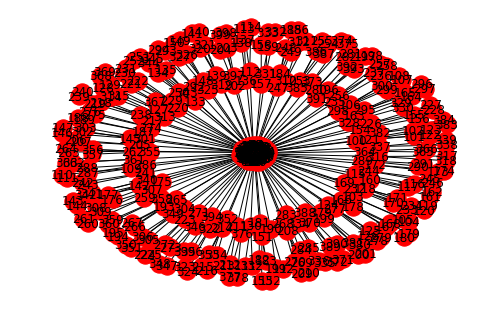

In [38]:
graph_1 = comm_surr_comm(100,3,100,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 120 elements and 6 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
[1] 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
    38, 39
[2] 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
    58, 59
[3] 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
    78, 79
[4] 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
    98, 99
[5] 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
    115, 116, 117, 118, 119



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 39.7368421053 :: iter 1
Old_SumQ 39.7368421053  
SumQ 119.5000000000 :: iter 2
Old_SumQ 119.5000000000  
SumQ 119.5000000000 :: iter 3
Our MaxPerm Implementation took 0.054085 seconds

total partitions : 6
[5] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[102] :  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 1

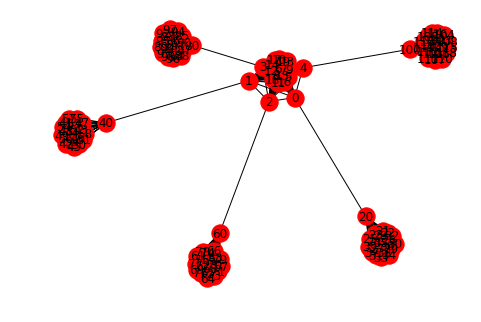

In [39]:
graph_1 = comm_surr_comm(20,20,5,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 80 elements and 20 clusters
[ 0] 0, 20, 21, 22
[ 1] 1, 23, 24, 25
[ 2] 2, 26, 27, 28
[ 3] 3, 29, 30, 31
[ 4] 4, 32, 33, 34
[ 5] 5, 35, 36, 37
[ 6] 6, 38, 39, 40
[ 7] 7, 41, 42, 43
[ 8] 8, 44, 45, 46
[ 9] 9, 47, 48, 49
[10] 10, 50, 51, 52
[11] 11, 53, 54, 55
[12] 12, 56, 57, 58
[13] 13, 59, 60, 61
[14] 14, 62, 63, 64
[15] 15, 65, 66, 67
[16] 16, 68, 69, 70
[17] 17, 71, 72, 73
[18] 18, 74, 75, 76
[19] 19, 77, 78, 79



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ -52.3333333333 :: iter 1
Old_SumQ -52.3333333333  
SumQ 34.3333333333 :: iter 2
Old_SumQ 34.3333333333  
SumQ 60.8833333333 :: iter 3
Old_SumQ 60.8833333333  
SumQ 72.3333333333 :: iter 4
Old_SumQ 72.3333333333  
SumQ 72.3333333333 :: iter 5
Our MaxPerm Implementation took 0.039107 seconds

total partitions : 21
[64] :  [62, 63, 64]
[34] :  [32, 33, 34]
[67] :  [65, 66, 67]
[37] :  [35, 36, 37]
[70] :  [68, 69, 70]
[40] :  [38, 39, 40]
[73] :  [71, 72, 73]
[43] :  [41, 42, 43]
[

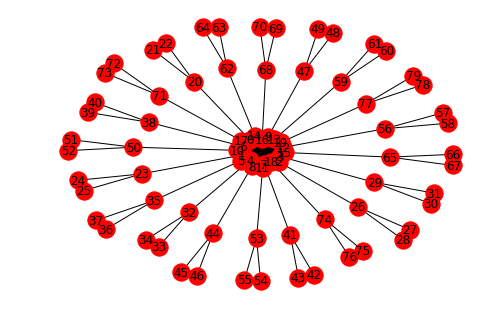

In [40]:
graph_1 = comm_surr_comm(20,3,20,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 70 elements and 11 clusters
[ 0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
[ 1] 20, 21, 22, 23, 24
[ 2] 25, 26, 27, 28, 29
[ 3] 30, 31, 32, 33, 34
[ 4] 35, 36, 37, 38, 39
[ 5] 40, 41, 42, 43, 44
[ 6] 45, 46, 47, 48, 49
[ 7] 50, 51, 52, 53, 54
[ 8] 55, 56, 57, 58, 59
[ 9] 60, 61, 62, 63, 64
[10] 65, 66, 67, 68, 69



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ -30.0000000000 :: iter 1
Old_SumQ -30.0000000000  
SumQ 57.3815789474 :: iter 2
Old_SumQ 57.3815789474  
SumQ 67.5000000000 :: iter 3
Old_SumQ 67.5000000000  
SumQ 67.5000000000 :: iter 4
Our MaxPerm Implementation took 0.026924 seconds

total partitions : 11
[32] :  [30, 31, 32, 33, 34]
[67] :  [65, 66, 67, 68, 69]
[37] :  [35, 36, 37, 38, 39]
[42] :  [40, 41, 42, 43, 44]
[47] :  [45, 46, 47, 48, 49]
[52] :  [50, 51, 52, 53, 54]
[22] :  [20, 21, 22, 23, 24]
[57] :  [55, 56, 57, 58, 59]
[27] :  [25, 26, 27, 28, 29]
[10] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,

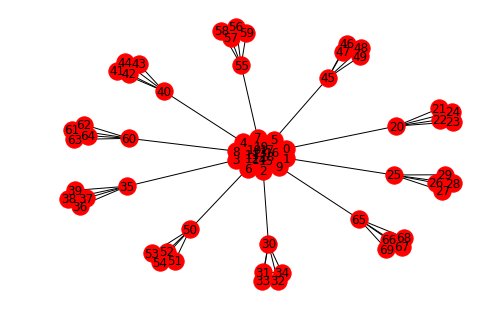

In [41]:
graph_1 = comm_surr_comm(20,5,10,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 20 elements and 6 clusters
[0] 0, 1, 2, 3, 4
[1] 5, 6, 7
[2] 8, 9, 10
[3] 11, 12, 13
[4] 14, 15, 16
[5] 17, 18, 19



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ -12.3333333333 :: iter 1
Old_SumQ -12.3333333333  
SumQ 13.5333333333 :: iter 2
Old_SumQ 13.5333333333  
SumQ 17.3333333333 :: iter 3
Old_SumQ 17.3333333333  
SumQ 17.3333333333 :: iter 4
Our MaxPerm Implementation took 0.000304 seconds

total partitions : 6
[7] :  [5, 6, 7]
[8] :  [0, 1, 2, 3, 4]
[10] :  [8, 9, 10]
[13] :  [11, 12, 13]
[16] :  [14, 15, 16]
[19] :  [17, 18, 19]


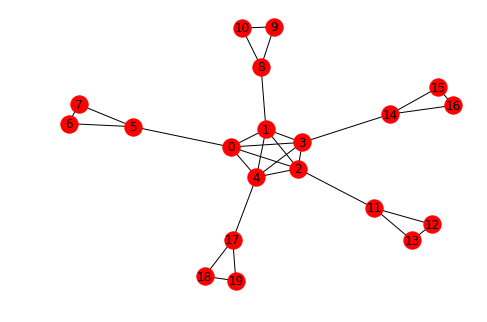

In [42]:
graph_1 = comm_surr_comm(5,3,5,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 24 elements and 7 clusters
[0] 0, 1, 2, 3, 4, 5
[1] 6, 7, 8
[2] 9, 10, 11
[3] 12, 13, 14
[4] 15, 16, 17
[5] 18, 19, 20
[6] 21, 22, 23



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ -15.0000000000 :: iter 1
Old_SumQ -15.0000000000  
SumQ 18.3333333333 :: iter 2
Old_SumQ 18.3333333333  
SumQ 21.0000000000 :: iter 3
Old_SumQ 21.0000000000  
SumQ 21.0000000000 :: iter 4
Our MaxPerm Implementation took 0.000454 seconds

total partitions : 7
[8] :  [6, 7, 8]
[11] :  [9, 10, 11]
[14] :  [12, 13, 14]
[17] :  [15, 16, 17]
[20] :  [18, 19, 20]
[21] :  [0, 1, 2, 3, 4, 5]
[23] :  [21, 22, 23]


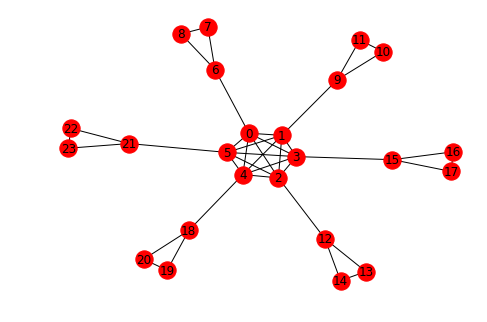

In [43]:
graph_1 = comm_surr_comm(6,3,6,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 110 elements and 11 clusters
[ 0] 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
     28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
     46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
     64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79
[ 1] 0, 80, 81, 82
[ 2] 1, 83, 84, 85
[ 3] 2, 86, 87, 88
[ 4] 3, 89, 90, 91
[ 5] 4, 92, 93, 94
[ 6] 5, 95, 96, 97
[ 7] 6, 98, 99, 100
[ 8] 7, 101, 102, 103
[ 9] 8, 104, 105, 106
[10] 9, 107, 108, 109



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ -96.5416666667 :: iter 1
Old_SumQ -96.5416666667  
SumQ -53.2083333333 :: iter 2
Old_SumQ -53.2083333333  
SumQ 65.7845464135 :: iter 3
Old_SumQ 65.7845464135  
SumQ 106.5416666667 :: iter 4
Old_SumQ 106.5416666667  
SumQ 106.5416666667 :: iter 5
Our MaxPerm Implementation took 8.873117 seconds

total partitions : 11
[97] :  [95, 96, 97]
[100] :  [98, 99, 100]
[103] :  [

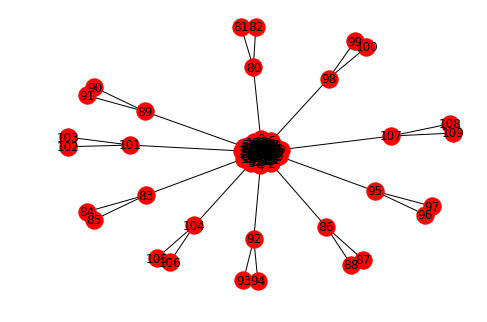

In [77]:
graph_1 = comm_surr_comm(80,3,10,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 410 elements and 11 clusters
[ 0] 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
     28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
     46, 47, 48, 49
[ 1] 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
     68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
     86, 87, 88, 89
[ 2] 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105,
     106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
     120, 121, 122, 123, 124, 125, 126, 127, 128, 129
[ 3] 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
     144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
     158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169
[ 4] 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
     184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
     198, 199, 200, 201, 202

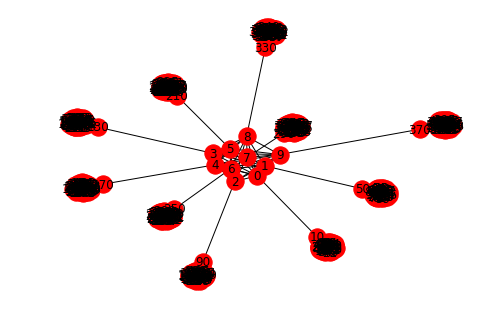

In [79]:
graph_1 = comm_surr_comm(10,40,10,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 55 elements and 6 clusters
[0] 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
[1] 15, 16, 17, 18, 19, 20, 21, 22, 23, 24
[2] 25, 26, 27, 28, 29, 30, 31, 32, 33, 34
[3] 35, 36, 37, 38, 39, 40, 41, 42, 43, 44
[4] 45, 46, 47, 48, 49, 50, 51, 52, 53, 54
[5] 0, 1, 2, 3, 4



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 6.2555555556 :: iter 1
Old_SumQ 6.2555555556  
SumQ 53.5000000000 :: iter 2
Old_SumQ 53.5000000000  
SumQ 53.5000000000 :: iter 3
Our MaxPerm Implementation took 0.002835 seconds

total partitions : 6
[1] :  [0, 1, 2, 3, 4]
[37] :  [35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
[7] :  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[47] :  [45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[17] :  [15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[27] :  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


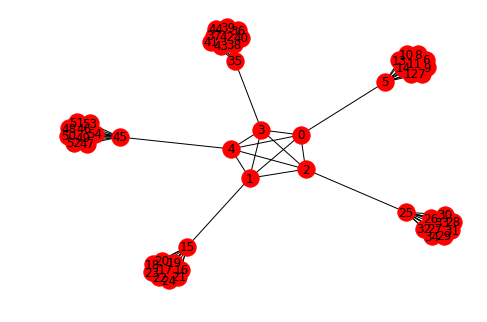

In [80]:
graph_1 = comm_surr_comm(5,10,5,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 550 elements and 6 clusters
[0] 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
    68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
    86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
    103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
    118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
    133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
    148, 149
[1] 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
    165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
    180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
    195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
    210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
    225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,

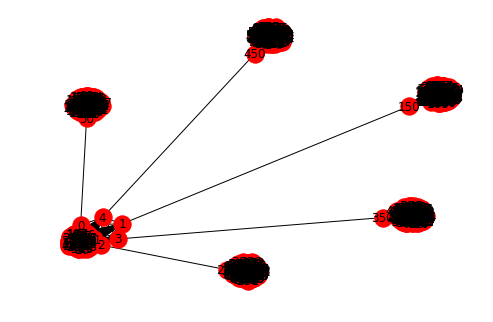

In [82]:
graph_1 = comm_surr_comm(50,100,5,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 265 elements and 12 clusters
[ 0] 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
     29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
     47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
     65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
     83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99
[ 1] 0, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
     114
[ 2] 1, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
     129
[ 3] 2, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
     144
[ 4] 3, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
     159
[ 5] 4, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
     174
[ 6] 5, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
     189
[ 7] 6, 190, 191, 192, 193, 194, 195, 196,

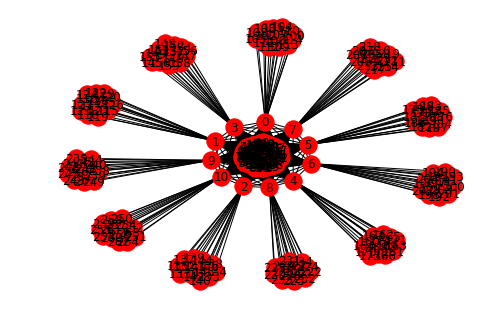

In [97]:
graph_1 = comm_surr_comm(100,15,11,15)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 200 elements and 12 clusters
[ 0] 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
     29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
     47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
     65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
     83, 84, 85, 86, 87, 88, 89
[ 1] 0, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99
[ 2] 1, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109
[ 3] 2, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119
[ 4] 3, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129
[ 5] 4, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139
[ 6] 5, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149
[ 7] 6, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159
[ 8] 7, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169
[ 9] 8, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179
[10] 9, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189
[11] 10, 190, 191, 192, 193, 194, 195, 196, 

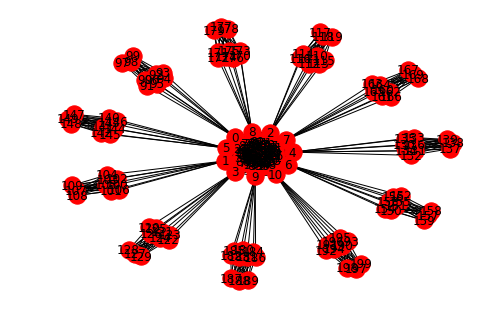

In [98]:
graph_1 = comm_surr_comm(90,10,11,7)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 30 elements and 6 clusters
[0] 5, 6, 7, 8, 9
[1] 0, 10, 11, 12, 13
[2] 1, 14, 15, 16, 17
[3] 2, 18, 19, 20, 21
[4] 3, 22, 23, 24, 25
[5] 4, 26, 27, 28, 29



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ -5.1987179487 :: iter 1
Old_SumQ -5.1987179487  
SumQ 22.5299145299 :: iter 2
Old_SumQ 22.5299145299  
SumQ 22.5299145299 :: iter 3
Our MaxPerm Implementation took 0.001555 seconds

total partitions : 6
[10] :  [5, 6, 7, 8, 9]
[11] :  [0, 10, 11, 12, 13]
[15] :  [1, 14, 15, 16, 17]
[19] :  [2, 18, 19, 20, 21]
[23] :  [3, 22, 23, 24, 25]
[27] :  [4, 26, 27, 28, 29]


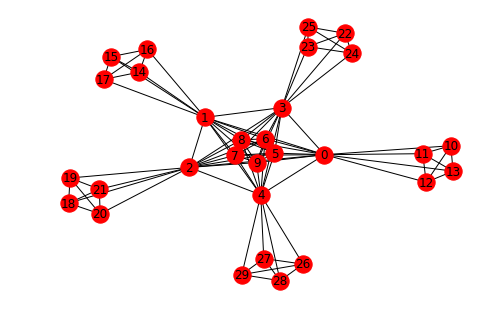

In [99]:
graph_1 = comm_surr_comm(10,4,5,4)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 55 elements and 6 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
[1] 20, 21, 22, 23, 24, 25, 26
[2] 27, 28, 29, 30, 31, 32, 33
[3] 34, 35, 36, 37, 38, 39, 40
[4] 41, 42, 43, 44, 45, 46, 47
[5] 48, 49, 50, 51, 52, 53, 54



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 15.8287764867 :: iter 1
Old_SumQ 15.8287764867  
SumQ 49.1450216450 :: iter 2
Old_SumQ 49.1450216450  
SumQ 49.2965367965 :: iter 3
Old_SumQ 49.2965367965  
SumQ 49.2965367965 :: iter 4
Our MaxPerm Implementation took 0.017303 seconds

total partitions : 6
[38] :  [34, 35, 36, 37, 38, 39, 40]
[45] :  [41, 42, 43, 44, 45, 46, 47]
[52] :  [48, 49, 50, 51, 52, 53, 54]
[25] :  [20, 21, 22, 23, 24, 25, 26]
[20] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[31] :  [27, 28, 29, 30, 31, 32, 33]


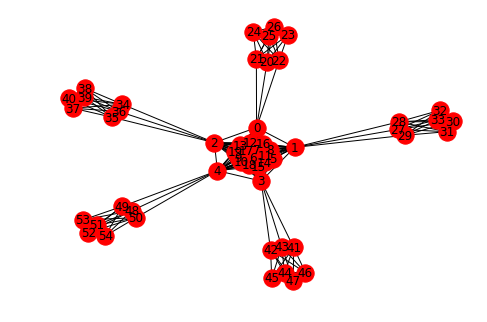

In [100]:
graph_1 = comm_surr_comm(20,7,5,3)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 14 elements and 2 clusters
[0] 0, 1, 2, 3, 4, 5, 6
[1] 7, 8, 9, 10, 11, 12, 13



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 4.3864468864 :: iter 1
Old_SumQ 4.3864468864  
SumQ 12.0897435897 :: iter 2
Old_SumQ 12.0897435897  
SumQ 12.0897435897 :: iter 3
Our MaxPerm Implementation took 0.000644 seconds

total partitions : 2
[8] :  [0, 7, 8, 9, 10, 11, 12, 13]
[5] :  [1, 2, 3, 4, 5, 6]


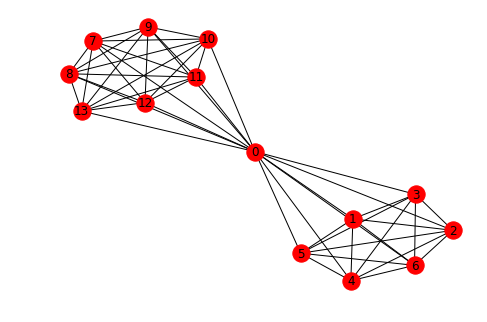

In [45]:
graph_1 = hub_node_graph(6,7)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 13 elements and 3 clusters
[0] 0, 1, 2, 3, 4
[1] 5, 6, 7, 8
[2] 9, 10, 11, 12



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 0.0833333333 :: iter 1
Old_SumQ 0.0833333333  
SumQ 10.5000000000 :: iter 2
Old_SumQ 10.5000000000  
SumQ 10.5000000000 :: iter 3
Our MaxPerm Implementation took 0.000121 seconds

total partitions : 1
[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


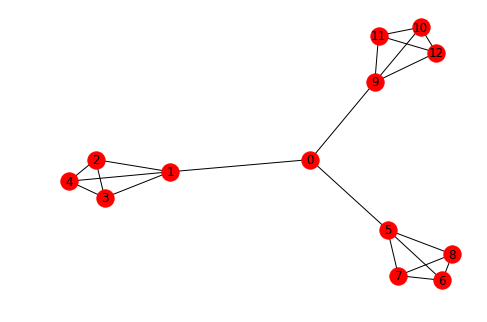

In [46]:
graph_1 = hub_surr_cliq(3,[4,4,4])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 9 elements and 2 clusters
[0] 0, 1, 2, 3, 4
[1] 5, 6, 7, 8



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 0.0000000000 :: iter 1
Old_SumQ 0.0000000000  
SumQ 7.0000000000 :: iter 2
Old_SumQ 7.0000000000  
SumQ 7.0000000000 :: iter 3
Our MaxPerm Implementation took 0.000091 seconds

total partitions : 1
[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8]


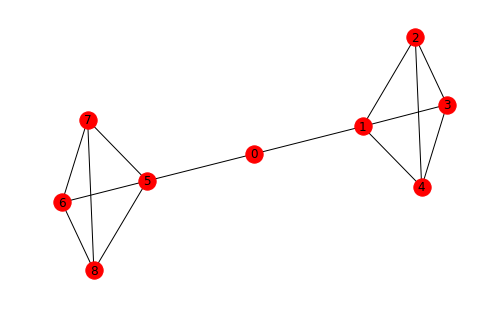

In [47]:
graph_1 = hub_surr_cliq(2,[4,4])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 105 elements and 2 clusters
[0] 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
    22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
    40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
    58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
    76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
    94, 95, 96, 97, 98, 99, 100
[1] 0, 1, 101, 102, 103, 104



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 47.7600000000 :: iter 1
Old_SumQ 47.7600000000  
SumQ 103.4800000000 :: iter 2
Old_SumQ 103.4800000000  
SumQ 103.4800000000 :: iter 3
Our MaxPerm Implementation took 19.408672 seconds

total partitions : 1
[101] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5

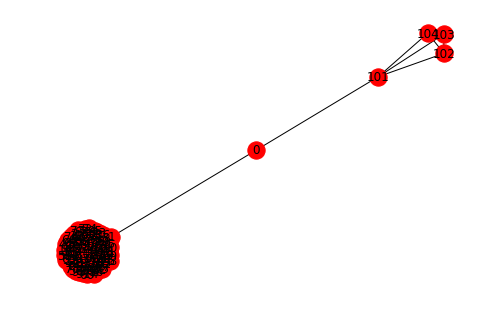

In [48]:
graph_1 = hub_surr_cliq(2,[100,4])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 41 elements and 2 clusters
[0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
[1] 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
    39, 40



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 15.6000000000 :: iter 1
Old_SumQ 15.6000000000  
SumQ 39.8000000000 :: iter 2
Old_SumQ 39.8000000000  
SumQ 39.8000000000 :: iter 3
Our MaxPerm Implementation took 0.016750 seconds

total partitions : 1
[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


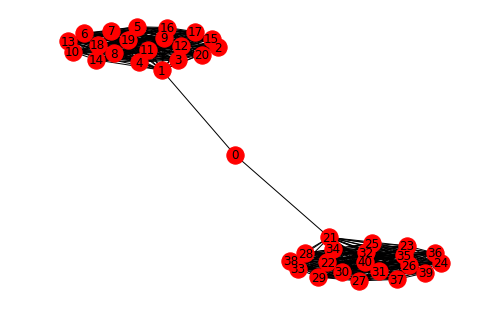

In [49]:
graph_1 = hub_surr_cliq(2,[20,20])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 29 elements and 3 clusters
[0] 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28
[1] 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
[2] 0, 1, 2, 3, 4, 5, 6



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 3.1000000000 :: iter 1
Old_SumQ 3.1000000000  
SumQ 26.4666666667 :: iter 2
Old_SumQ 26.4666666667  
SumQ 26.4666666667 :: iter 3
Our MaxPerm Implementation took 0.003367 seconds

total partitions : 3
[1] :  [0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[3] :  [1, 2, 3]
[6] :  [4, 5, 6]


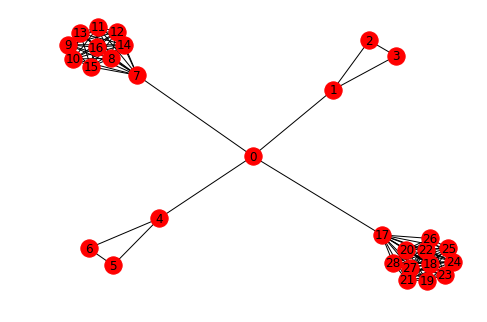

In [55]:
graph_1 = hub_surr_cliq(4,[3,3,10,12])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 39 elements and 5 clusters
[0] 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38
[1] 17, 18, 19, 20, 21, 22, 23, 24, 25, 26
[2] 0, 1, 2, 3, 4, 5, 6, 7
[3] 12, 13, 14, 15, 16
[4] 8, 9, 10, 11



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 0.8000000000 :: iter 1
Old_SumQ 0.8000000000  
SumQ 35.8666666667 :: iter 2
Old_SumQ 35.8666666667  
SumQ 35.9333333333 :: iter 3
Old_SumQ 35.9333333333  
SumQ 35.9333333333 :: iter 4
Our MaxPerm Implementation took 0.002035 seconds

total partitions : 5
[10] :  [8, 9, 10, 11]
[3] :  [1, 2, 3, 4]
[5] :  [0, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
[14] :  [12, 13, 14, 15, 16]
[7] :  [5, 6, 7]


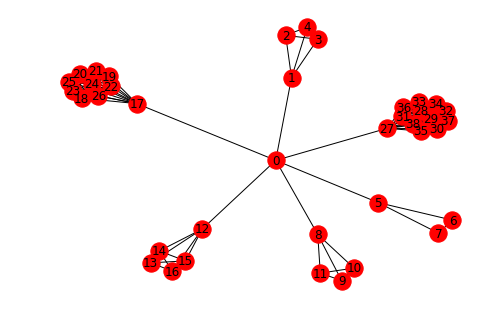

In [56]:
graph_1 = hub_surr_cliq(6,[4,3 ,4 ,5,10,12])
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
('start node : ', 323, 'end node : ', 375)
LOUVAIN : 
Clustering with 376 elements and 21 clusters
[ 0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 26, 27,
     28, 29, 30, 31, 32, 33
[ 1] 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
     363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375
[ 2] 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
     337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348
[ 3] 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311,
     312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322
[ 4] 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287,
     288, 289, 290, 291, 292, 293, 294, 295, 296, 297
[ 5] 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
     265, 266, 267, 268, 269, 270, 271, 272, 273
[ 6] 229, 230, 231, 232, 233, 

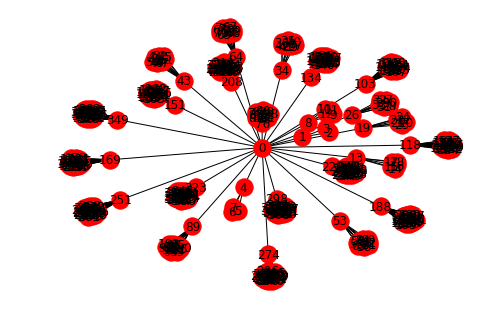

In [63]:
cliq = [i + 3 for i in range(25)]
print(cliq)
print("start node : ",sum(cliq[:-2]) + 1, "end node : ", sum(cliq))
graph_1 = hub_surr_cliq(25,cliq)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
('start node : ', 139, 'end node : ', 150)
LOUVAIN : 
Clustering with 151 elements and 25 clusters
[ 0] 0, 1, 2, 3, 4, 5, 6
[ 1] 7, 8, 9, 10, 11, 12
[ 2] 13, 14, 15, 16, 17, 18
[ 3] 19, 20, 21, 22, 23, 24
[ 4] 25, 26, 27, 28, 29, 30
[ 5] 31, 32, 33, 34, 35, 36
[ 6] 37, 38, 39, 40, 41, 42
[ 7] 43, 44, 45, 46, 47, 48
[ 8] 49, 50, 51, 52, 53, 54
[ 9] 55, 56, 57, 58, 59, 60
[10] 61, 62, 63, 64, 65, 66
[11] 67, 68, 69, 70, 71, 72
[12] 73, 74, 75, 76, 77, 78
[13] 79, 80, 81, 82, 83, 84
[14] 85, 86, 87, 88, 89, 90
[15] 91, 92, 93, 94, 95, 96
[16] 97, 98, 99, 100, 101, 102
[17] 103, 104, 105, 106, 107, 108
[18] 109, 110, 111, 112, 113, 114
[19] 115, 116, 117, 118, 119, 120
[20] 121, 122, 123, 124, 125, 126
[21] 127, 128, 129, 130, 131, 132
[22] 133, 134, 135, 136, 137, 138
[23] 139, 140, 141, 142, 143, 144
[24] 145, 146, 147, 148, 149, 150



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ -16.7933

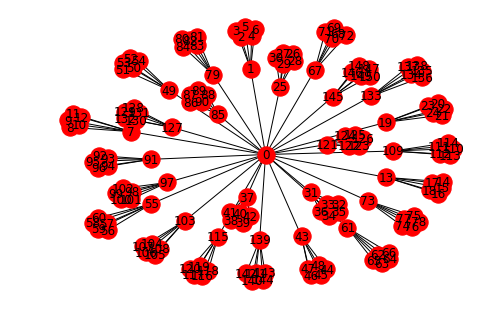

In [64]:
cliq = [6 for i in range(25)]
print(cliq)
print("start node : ",sum(cliq[:-2]) + 1, "end node : ", sum(cliq))
graph_1 = hub_surr_cliq(25,cliq)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

[26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]
('start node : ', 573, 'end node : ', 624)
LOUVAIN : 
Clustering with 625 elements and 24 clusters
[ 0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
     21, 22, 23, 24, 25, 26
[ 1] 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
     45, 46, 47, 48, 49, 50, 51, 52
[ 2] 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
     71, 72, 73, 74, 75, 76, 77, 78
[ 3] 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
     97, 98, 99, 100, 101, 102, 103, 104
[ 4] 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
     119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130
[ 5] 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
     145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156
[ 6] 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,


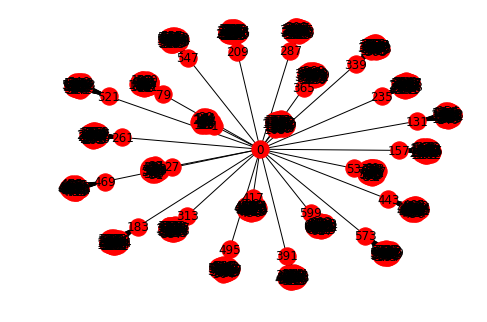

In [72]:
cliq = [26 for i in range(24)]
print(cliq)
print("start node : ",sum(cliq[:-2]) + 1, "end node : ", sum(cliq))
graph_1 = hub_surr_cliq(len(cliq),cliq)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
('start node : ', 551, 'end node : ', 600)
LOUVAIN : 
Clustering with 601 elements and 24 clusters
[ 0] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
     21, 22, 23, 24, 25
[ 1] 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
     44, 45, 46, 47, 48, 49, 50
[ 2] 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
     69, 70, 71, 72, 73, 74, 75
[ 3] 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
     94, 95, 96, 97, 98, 99, 100
[ 4] 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
     115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125
[ 5] 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
     140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150
[ 6] 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
     165, 166, 167, 168, 169, 

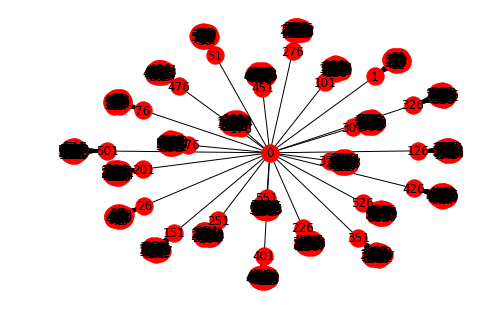

In [74]:
cliq = [25 for i in range(24)]
print(cliq)
print("start node : ",sum(cliq[:-2]) + 1, "end node : ", sum(cliq))
graph_1 = hub_surr_cliq(len(cliq),cliq)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 25]
('start node : ', 461, 'end node : ', 505)
LOUVAIN : 
Clustering with 506 elements and 25 clusters
[ 0] 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494,
     495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505
[ 1] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
[ 2] 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
     39, 40
[ 3] 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
     59, 60
[ 4] 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
     79, 80
[ 5] 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
     99, 100
[ 6] 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
     115, 116, 117, 118, 119, 120
[ 7] 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
     135, 136, 137, 138, 139, 140
[ 8] 141, 142

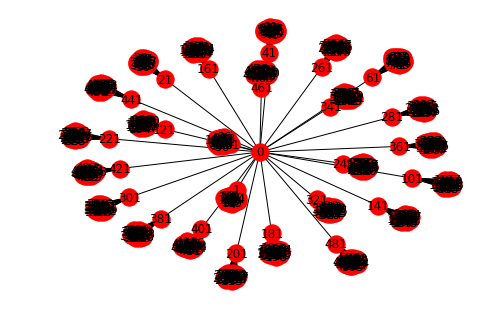

In [76]:
cliq = [20 for i in range(24)]
cliq.append(25)
print(cliq)
print("start node : ",sum(cliq[:-2]) + 1, "end node : ", sum(cliq))
graph_1 = hub_surr_cliq(len(cliq),cliq)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 16 elements and 2 clusters
[0] 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
[1] 0, 1, 2, 3, 4, 5



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 5.4095238095 :: iter 1
Old_SumQ 5.4095238095  
SumQ 14.4904761905 :: iter 2
Old_SumQ 14.4904761905  
SumQ 14.4904761905 :: iter 3
Our MaxPerm Implementation took 0.000940 seconds

total partitions : 2
[9] :  [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[5] :  [0, 1, 2, 3, 4, 5]


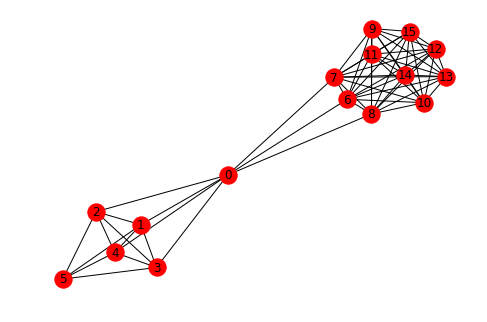

In [87]:
graph_1 = hub_node_generic(10,5,3,4)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 31 elements and 2 clusters
[0] 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
    29, 30
[1] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 12.7175438596 :: iter 1
Old_SumQ 12.7175438596  
SumQ 29.4166666667 :: iter 2
Old_SumQ 29.4166666667  
SumQ 29.4166666667 :: iter 3
Our MaxPerm Implementation took 0.013101 seconds

total partitions : 2
[15] :  [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[7] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


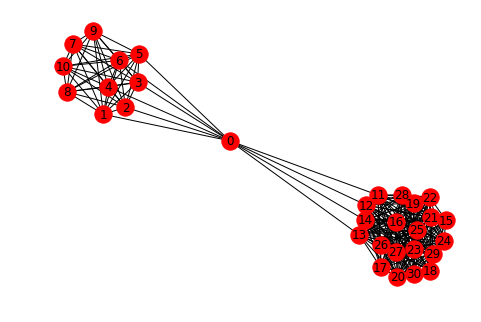

In [88]:
graph_1 = hub_node_generic(20,10,4,6)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 31 elements and 2 clusters
[0] 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
    29, 30
[1] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 12.8774122807 :: iter 1
Old_SumQ 12.8774122807  
SumQ 29.0041666667 :: iter 2
Old_SumQ 29.0041666667  
SumQ 29.0041666667 :: iter 3
Our MaxPerm Implementation took 0.019349 seconds

total partitions : 2
[21] :  [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[7] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


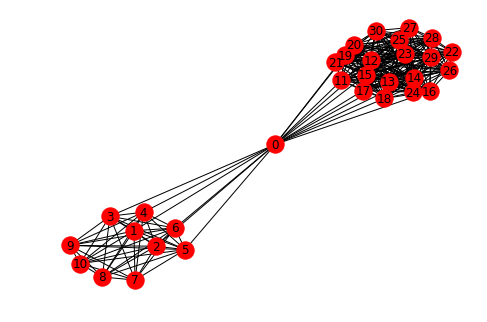

In [89]:
graph_1 = hub_node_generic(20,10,10,6)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 31 elements and 2 clusters
[0] 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
    29, 30
[1] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 10.6500000000 :: iter 1
Old_SumQ 10.6500000000  
SumQ 29.7000000000 :: iter 2
Old_SumQ 29.7000000000  
SumQ 29.7000000000 :: iter 3
Our MaxPerm Implementation took 0.008927 seconds

total partitions : 1
[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


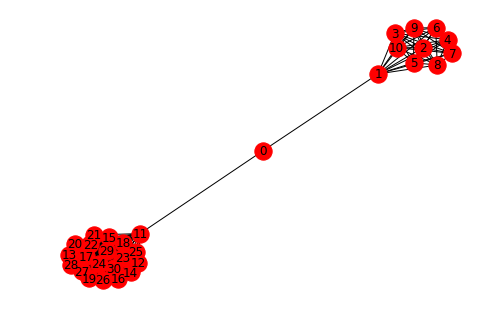

In [90]:
graph_1 = hub_node_generic(20,10,1,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 31 elements and 2 clusters
[0] 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
    29, 30
[1] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 11.5307017544 :: iter 1
Old_SumQ 11.5307017544  
SumQ 29.9438596491 :: iter 2
Old_SumQ 29.9438596491  
SumQ 29.9438596491 :: iter 3
Our MaxPerm Implementation took 0.009688 seconds

total partitions : 1
[1] :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


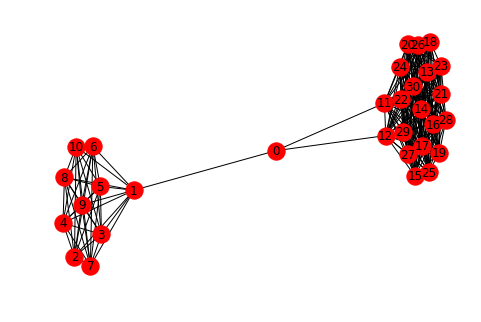

In [91]:
graph_1 = hub_node_generic(20,10,2,1)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])

LOUVAIN : 
Clustering with 31 elements and 2 clusters
[0] 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
    29, 30
[1] 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10



MAXPERM : 
-2147483647.000000
Old_SumQ -2147483646.0000000000  
SumQ 12.5754385965 :: iter 1
Old_SumQ 12.5754385965  
SumQ 29.5982456140 :: iter 2
Old_SumQ 29.5982456140  
SumQ 29.5982456140 :: iter 3
Our MaxPerm Implementation took 0.010560 seconds

total partitions : 2
[1] :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[14] :  [0, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


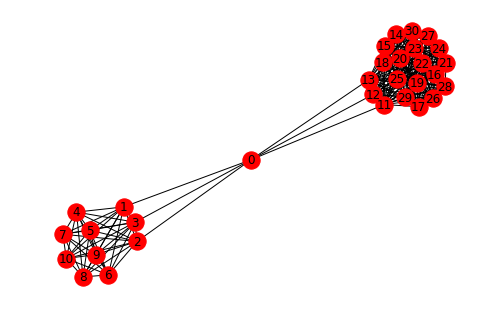

In [92]:
graph_1 = hub_node_generic(20,10,3,3)
print("LOUVAIN : ")
run_louvain(graph_1[0],graph_1[1])
print("\n\n")
print("MAXPERM : ")
run_maxperm(graph_1[0],graph_1[1])